In [1]:
!pip install pyspark matplotlib pandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pyspark
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, count, col, datediff, when
from pyspark.sql import DataFrame
import os

In [3]:
# Crear o recuperar una sesión de Spark
spark = SparkSession.builder.appName("Lambda_Analytics").getOrCreate()

24/10/21 10:59:52 WARN Utils: Your hostname, casameher-Lenovo-C260 resolves to a loopback address: 127.0.1.1; using 192.168.20.23 instead (on interface enp2s0)
24/10/21 10:59:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/21 10:59:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Cargar Datos

In [4]:
# Cargar archivos CSV en un DataFrame de Spark
csv_files = [
    "Escritorio/pruebas_lambda/entrevista/proveedores.csv",
    "Escritorio/pruebas_lambda/entrevista/compras.csv",
    "Escritorio/pruebas_lambda/entrevista/proyectos.csv",
    "Escritorio/pruebas_lambda/entrevista/inventario.csv",
    "Escritorio/pruebas_lambda/entrevista/interacciones.csv",
    "Escritorio/pruebas_lambda/entrevista/promociones.csv"
]
dataframes = {}

try:
    for file in csv_files:
        name = os.path.basename(file).replace('.csv', '')
        dataframes[name] = spark.read.csv(file, header=True, inferSchema=True)
    print("Archivos cargados correctamente.")
except Exception as e:
    print("Error al cargar los archivos CSV:", e)

Archivos cargados correctamente.


## Limpieza de Datos

In [5]:
# Limpieza de Datos
for name, df in dataframes.items():
    dataframes[name] = df.dropDuplicates().fillna(0)  # Eliminar duplicados y llenar nulos con 0

# Mostrar muestras de los datos para verificar que estén limpios
for name, df in dataframes.items():
    df.show(5)

+------------+-----------+---------+------------+------------+--------------+
|proveedor_id|     nombre|ubicacion|   categoria|calificacion|tiempo_entrega|
+------------+-----------+---------+------------+------------+--------------+
|          28|Proveedor G|     Este|   Servicios|           1|             9|
|          46|Proveedor B|    Norte|Herramientas|           5|             7|
|          31|Proveedor C|     Este|Herramientas|           4|             1|
|          92|Proveedor E|     Este|     Equipos|           3|             5|
|          38|Proveedor B|    Oeste|     Equipos|           5|            16|
+------------+-----------+---------+------------+------------+--------------+
only showing top 5 rows



+-----------+------------+----------+---------+--------+------------------+------------------+------------------+
|proyecto_id|proveedor_id|     fecha| material|cantidad|             costo|fecha_comprometida|fecha_entrega_real|
+-----------+------------+----------+---------+--------+------------------+------------------+------------------+
|          4|          20|2023-08-13|Ladrillos|     675| 19358.12004742254|        2021-03-23|        2021-03-23|
|          5|          40|2022-01-28|  Cemento|     696|13992.925783153407|        2023-08-30|        2023-08-29|
|          8|          14|2023-12-12|Ladrillos|     814|32377.796969345643|        2022-04-13|        2022-04-13|
|         13|          70|2022-02-28|Ladrillos|     688| 9006.637644872253|        2021-08-24|        2021-08-23|
|         17|          91|2021-06-06|Ladrillos|     610| 8301.160654565303|        2022-02-13|        2022-02-15|
+-----------+------------+----------+---------+--------+------------------+-------------

+-----------+-------------+---------+------+--------+
|proyecto_id|tipo_proyecto|ubicacion|tamaño|duracion|
+-----------+-------------+---------+------+--------+
|         53|  Residencial|    Oeste|  6384|      18|
|        251|  Residencial|     Este|  9174|       5|
|        775|  Residencial|    Oeste|  4678|       4|
|        926|  Residencial|    Oeste|  9505|       8|
|        983|    Comercial|     Este|  2802|       2|
+-----------+-------------+---------+------+--------+
only showing top 5 rows

+---------+--------+-------------------+------------------+
| material|cantidad|fecha_ultima_compra|    costo_promedio|
+---------+--------+-------------------+------------------+
|  Cemento|    2191|         2021-01-31| 778.1867444637014|
|   Madera|    4889|         2021-04-30|1556.4163283497185|
|Ladrillos|    3959|         2021-02-28| 4439.801767916255|
|    Acero|    1682|         2021-03-31| 1513.910533549861|
+---------+--------+-------------------+------------------+



+------------+------------------+-------------------+
|proveedor_id|  tipo_interaccion|              fecha|
+------------+------------------+-------------------+
|          27|Correo Electrónico|2021-01-01 23:00:00|
|          87|Correo Electrónico|2021-01-06 16:00:00|
|          86|Correo Electrónico|2021-01-10 12:00:00|
|          58|           Llamada|2021-01-19 17:00:00|
|          41|Correo Electrónico|2021-02-13 11:00:00|
+------------+------------------+-------------------+
only showing top 5 rows



+------------+------------------+------------+-------+
|proveedor_id|           campaña|fecha_inicio|impacto|
+------------+------------------+------------+-------+
|          15|         Descuento|  2021-08-29|     22|
|          60|         Promoción|  2030-04-14|     58|
|          88|         Descuento|  2021-08-08|     49|
|           1|Ofertas Especiales|  2023-03-19|     65|
|          94|Ofertas Especiales|  2028-06-25|     81|
+------------+------------------+------------+-------+
only showing top 5 rows



## Análisis Exploratorio 

### a) Tendencias y patrones en compras
### b) Patrones y Anomalías de compras

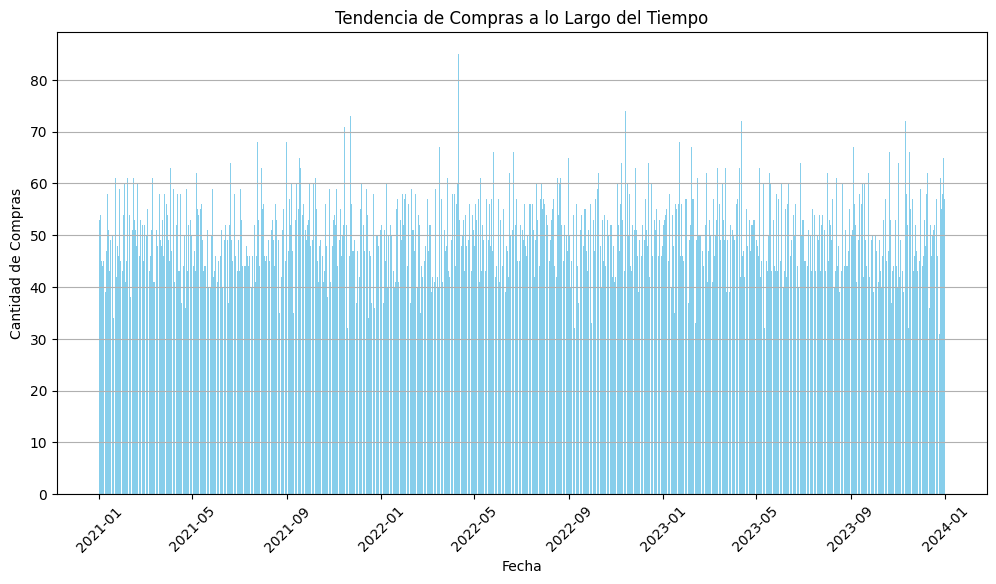

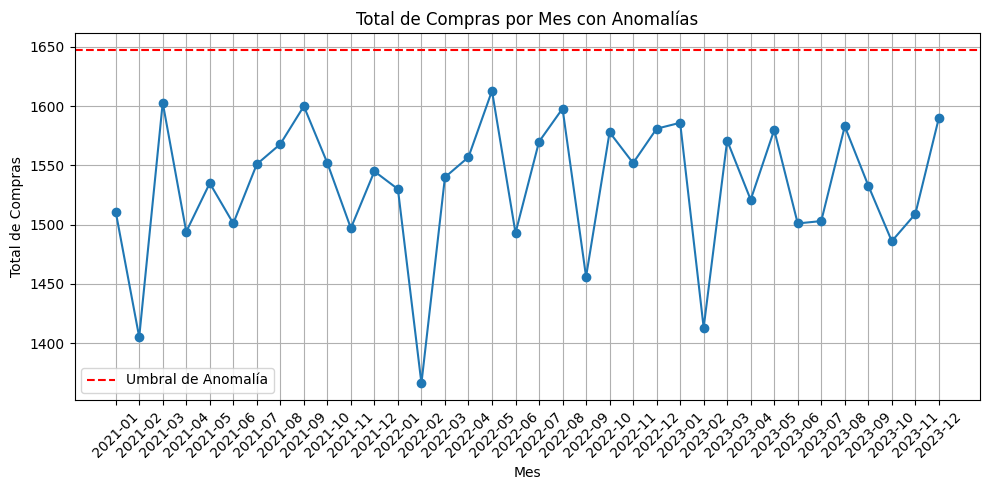

In [6]:
# Análisis Exploratorio
compras_df = dataframes['compras']

# Tendencias y patrones en compras
tendencia_compras = compras_df.groupBy("fecha").count().orderBy("fecha")
tendencia_compras_pd = tendencia_compras.toPandas()

# Graficar tendencias de compras
plt.figure(figsize=(12, 6))
plt.bar(tendencia_compras_pd['fecha'], tendencia_compras_pd['count'], color='skyblue')
plt.title('Tendencia de Compras a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Compras')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Calcular totales de compras por mes
compras_por_mes = compras_df.groupBy(F.date_format("fecha", "yyyy-MM").alias("mes")).agg(
    F.count("cantidad").alias("total_compras")
).orderBy("mes")

compras_por_mes_pd = compras_por_mes.toPandas()

# Identificar anomalías
mean = compras_por_mes_pd['total_compras'].mean()
std_dev = compras_por_mes_pd['total_compras'].std()
umbral = mean + 2 * std_dev
compras_por_mes_pd['anomalía'] = compras_por_mes_pd['total_compras'] > umbral

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(compras_por_mes_pd['mes'], compras_por_mes_pd['total_compras'], marker='o', linestyle='-')
plt.axhline(y=umbral, color='r', linestyle='--', label='Umbral de Anomalía')
plt.title('Total de Compras por Mes con Anomalías')
plt.xlabel('Mes')
plt.ylabel('Total de Compras')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()



### c) Evaluación de proveedores

In [7]:
# Evaluación de proveedores
compras_df = compras_df.withColumn("tiempo_entrega", datediff(col("fecha_entrega_real"), col("fecha_comprometida")))
tiempos_promedio_entrega = compras_df.groupBy("proveedor_id").agg(avg("tiempo_entrega").alias("tiempo_entrega_promedio"))
cumplimiento_entregas = compras_df.groupBy("proveedor_id").agg(
    (count(when(col("fecha_entrega_real") <= col("fecha_comprometida"), True)) / count("fecha_comprometida") * 100).alias("cumplimiento_tiempo_entrega")
)
cantidades_promedio = compras_df.groupBy("proveedor_id").agg(avg("cantidad").alias("cantidad_promedio"))
valor_promedio = compras_df.groupBy("proveedor_id").agg(avg("costo").alias("valor_promedio"))

# Unir resultados en un solo DataFrame
resultados_finales = tiempos_promedio_entrega.join(cumplimiento_entregas, "proveedor_id") \
    .join(cantidades_promedio, "proveedor_id") \
    .join(valor_promedio, "proveedor_id")

resultados_finales.show()

+------------+-----------------------+---------------------------+------------------+------------------+
|proveedor_id|tiempo_entrega_promedio|cumplimiento_tiempo_entrega| cantidad_promedio|    valor_promedio|
+------------+-----------------------+---------------------------+------------------+------------------+
|          31|    0.07604562737642585|          71.10266159695817| 504.0361216730038|15708.858175266303|
|          85|   -0.03773584905660377|          76.79245283018868|496.18490566037735|15335.821523121569|
|          65|   -0.02197802197802198|          74.17582417582418|488.14102564102564| 14718.85790884655|
|          53|   -0.01615798922800718|          73.24955116696589| 500.5583482944345| 15379.26099916375|
|          78|   -0.04788213627992634|          76.24309392265194|477.22467771639043|14432.498085662734|
|          34|   0.011326860841423949|          74.27184466019418|499.39644012944984|14908.732540648467|
|          81|   -0.01711026615969...|           75.285

## Modelado Predictivo

In [8]:
# Preparación de datos
compras = dataframes['compras']
proyectos = dataframes['proyectos']

# Seleccionar columnas relevantes
proyectos_seleccionados = proyectos.select("proyecto_id", "tipo_proyecto", "ubicacion", "tamaño", "duracion")
compras_seleccionadas = compras.select("proyecto_id", "material", "cantidad", "costo")

# Unir tablas
datos_unidos = compras_seleccionadas.join(proyectos_seleccionados, on="proyecto_id").na.drop()

# Convertir columnas categóricas a numéricas
indexer_tipo_proyecto = StringIndexer(inputCol="tipo_proyecto", outputCol="tipo_proyecto_index")
indexer_ubicacion = StringIndexer(inputCol="ubicacion", outputCol="ubicacion_index")
datos_indexados = indexer_tipo_proyecto.fit(datos_unidos).transform(datos_unidos)
datos_indexados = indexer_ubicacion.fit(datos_indexados).transform(datos_indexados)

# Preparar características
columnas_caracteristicas = ["tipo_proyecto_index", "ubicacion_index", "tamaño", "duracion", "costo"]
assembler = VectorAssembler(inputCols=columnas_caracteristicas, outputCol="features")
datos_modelo = assembler.transform(datos_indexados)

# Entrenar modelo de regresión lineal
lr = LinearRegression(featuresCol="features", labelCol="cantidad")
modelo = lr.fit(datos_modelo)

# Resumen del modelo
modelo_summary = modelo.summary
print(f"RMSE: {modelo_summary.rootMeanSquaredError}")
print(f"R2: {modelo_summary.r2}")

# Predicciones
predicciones = modelo.transform(datos_modelo)
predicciones.select("features", "cantidad", "prediction").show()

# Finalizar la sesión de Spark
spark.stop()

24/10/21 11:01:51 WARN Instrumentation: [59745679] regParam is zero, which might cause numerical instability and overfitting.


RMSE: 175.63321245564316
R2: 0.6252346909479332


+--------------------+--------+------------------+
|            features|cantidad|        prediction|
+--------------------+--------+------------------+
|[0.0,0.0,5352.0,1...|     675|  592.727784031795|
|[0.0,3.0,4499.0,3...|     696| 479.2234468438566|
|[1.0,1.0,5545.0,2...|     814| 861.3670980807478|
|[2.0,0.0,9306.0,1...|     688| 376.7788040963338|
|[1.0,2.0,7036.0,2...|     610|360.02187818378536|
|[2.0,1.0,9006.0,1...|     593| 638.0565813017732|
|[2.0,1.0,9006.0,1...|     645| 522.2775631364126|
|[2.0,2.0,6112.0,1...|     588| 751.5852496008888|
|[1.0,1.0,7251.0,9...|     468|293.05373603061526|
|[2.0,2.0,6994.0,2...|     429| 323.1324022799233|
|[1.0,2.0,6887.0,9...|     694| 373.7094752357633|
|[2.0,2.0,3630.0,1...|     834| 949.6691441082228|
|[2.0,2.0,7152.0,2...|     669| 769.8830020951805|
|[0.0,3.0,2459.0,7...|     474| 589.4783353970681|
|[0.0,1.0,8205.0,2...|     890| 913.8657675651777|
|[0.0,1.0,8205.0,2...|     581| 601.5837434683558|
|[0.0,3.0,8736.0,5...|      25|